#Implementing EM for Gaussian mixtures

In this assignment you will

implement the EM algorithm for a Gaussian mixture model
apply your implementation to cluster images
explore clustering results and interpret the output of the EM algorithm

##Import packages

In [1]:
import pandas as pd                                                 
import numpy as np                                             # dense matrices
import matplotlib.pyplot as plt                                # plotting
from scipy.stats import multivariate_normal                    # multivariate Gaussian distribution
import copy                                                    # deep copies

# image handling library
from PIL import Image
from io import BytesIO

%matplotlib inline

##Implementing the EM algorithm for Gaussian mixture models

In [2]:
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll

###E-step: assign cluster responsibilities, given current parameters.

The first step in the EM algorithm is to compute cluster responsibilities. Let rik denote the responsibility of cluster k for data point i. Note that cluster responsibilities are fractional parts: Cluster responsibilities for a single data point i should sum to 1.

ri1+ri2+…+riK=1
To figure how much a cluster is responsible for a given data point, we compute the likelihood of the data point under the particular cluster assignment, multiplied by the weight of the cluster. For data point i and cluster k, this quantity is

rik∝πkN(xi|μk,Σk)
where N(xi|μk,Σk) is the Gaussian distribution for cluster k (with mean μk and covariance Σk).

We used ∝ because the quantity N(xi|μk,Σk) is not yet the responsibility we want. To ensure that all responsibilities over each data point add up to 1, we add the normalization constant in the denominator:

rik=πkN(xi|μk,Σk)∑Kk=1πkN(xi|μk,Σk).
Complete the following function that computes rik for all data points i and clusters k.

###Drawing from a Gaussian distribution. 

In [3]:
def compute_responsibilities(data, weights, means, covariances):
    '''E-step: compute responsibilities, given the current parameters'''
    num_data = len(data)
    num_clusters = len(means)
    resp = np.zeros((num_data, num_clusters))
    
    # Update resp matrix so that resp[i,k] is the responsibility of cluster k for data point i.
    # Hint: To compute likelihood of seeing data point i given cluster k, use multivariate_normal.pdf.
    for i in range(num_data):
        for k in range(num_clusters):
            # YOUR CODE HERE
            resp[i, k] = weights[k]*multivariate_normal.pdf(data[i], mean=means[k], cov=covariances[k])
    
    # Add up responsibilities over each data point and normalize
    row_sums = resp.sum(axis=1)[:, np.newaxis]
    resp = resp / row_sums
    
    return resp

####Checkpoint

In [4]:
resp = compute_responsibilities(data=np.array([[1.,2.],[-1.,-2.]]), weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])

if resp.shape==(2,2) and np.allclose(resp, np.array([[0.10512733, 0.89487267], [0.46468164, 0.53531836]])):
    print 'Checkpoint passed!'
else:
    print 'Check your code again.'

Checkpoint passed!


##M-step: Update parameters, given current cluster responsibilities.

In [5]:
def compute_soft_counts(resp):
    # Compute the total responsibility assigned to each cluster, which will be useful when 
    # implementing M-steps below. In the lectures this is called N^{soft}
    counts = np.sum(resp, axis=0)
    return counts

###Updating weights

In [6]:
def compute_weights(counts):
    num_clusters = len(counts)
    weights = [0.] * num_clusters
    
    for k in range(num_clusters):
        # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
        # HINT: compute # of data points by summing soft counts.
        # YOUR CODE HERE
        
        weights[k] = counts[k]/np.sum(counts)

    return weights

####Checkpoint

In [7]:
resp = compute_responsibilities(data=np.array([[1.,2.],[-1.,-2.],[0,0]]), weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
weights = compute_weights(counts)

print counts
print weights

if np.allclose(weights, [0.27904865942515705, 0.720951340574843]):
    print 'Checkpoint passed!'
else:
    print 'Check your code again.'

[ 0.83714598  2.16285402]
[0.27904865942515705, 0.720951340574843]
Checkpoint passed!


###Updating means

The mean of each cluster is set to the weighted average of all data points, weighted by the cluster responsibilities:

μ^k=1Nsoftk∑Ni=1rikxi

In [8]:
def compute_means(data, resp, counts):
    num_clusters = len(counts)
    num_data = len(data)
    means = [np.zeros(len(data[0]))] * num_clusters
    
    for k in range(num_clusters):
        # Update means for cluster k using the M-step update rule for the mean variables.
        # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
        weighted_sum = 0.
        for i in range(num_data):
            # YOUR CODE HERE
            weighted_sum += data[i]*resp[i][k]
        # YOUR CODE HERE
        means[k] = weighted_sum/counts[k]

    return means

####Checkpoint

In [9]:
data_tmp = np.array([[1.,2.],[-1.,-2.]])
resp = compute_responsibilities(data=data_tmp, weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
means = compute_means(data_tmp, resp, counts)

if np.allclose(means, np.array([[-0.6310085, -1.262017], [0.25140299, 0.50280599]])):
    print 'Checkpoint passed!'
else:
    print 'Check your code again.'

Checkpoint passed!


###Updating covariances

In [10]:
def compute_covariances(data, resp, counts, means):
    num_clusters = len(counts)
    num_dim = len(data[0])
    num_data = len(data)
    covariances = [np.zeros((num_dim,num_dim))] * num_clusters
    
    for k in range(num_clusters):
        # Update covariances for cluster k using the M-step update rule for covariance variables.
        # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
        weighted_sum = np.zeros((num_dim, num_dim))
        for i in range(num_data):
            # YOUR CODE HERE (Hint: Use np.outer on the data[i] and this cluster's mean)
            weighted_sum += np.outer((data[i]-means[k]),(data[i]-means[k]))*resp[i][k]
        # YOUR CODE HERE
        covariances[k] = weighted_sum/counts[k]

    return covariances

####Checkpoint

In [11]:
data_tmp = np.array([[1.,2.],[-1.,-2.]])
resp = compute_responsibilities(data=data_tmp, weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
means = compute_means(data_tmp, resp, counts)
covariances = compute_covariances(data_tmp, resp, counts, means)

if np.allclose(covariances[0], np.array([[0.60182827, 1.20365655], [1.20365655, 2.4073131]])) and \
    np.allclose(covariances[1], np.array([[ 0.93679654, 1.87359307], [1.87359307, 3.74718614]])):
    print 'Checkpoint passed!'
else:
    print 'Check your code again.'

Checkpoint passed!


###The EM algorithm

In [12]:
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for it in range(maxiter):
        if it % 5 == 0:
            print("Iteration %s" % it)
        
        # E-step: compute responsibilities
        resp = compute_responsibilities(data, weights, means, covariances)

        # M-step
        # Compute the total responsibility assigned to each cluster, which will be useful when 
        # implementing M-steps below. In the lectures this is called N^{soft}
        counts = compute_soft_counts(resp)
        
        # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
        # YOUR CODE HERE
        weights = compute_weights(counts)
        
        # Update means for cluster k using the M-step update rule for the mean variables.
        # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
        # YOUR CODE HERE
        means = compute_means(data, resp, counts)
        
        # Update covariances for cluster k using the M-step update rule for covariance variables.
        # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
        # YOUR CODE HERE
        covariances = compute_covariances(data, resp, counts, means)
        
        # Compute the loglikelihood at this iteration
        # YOUR CODE HERE
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if it % 5 != 0:
        print("Iteration %s" % it)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

##Testing the implementation on the simulated data

In [13]:
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.
        k = np.random.choice(len(weights), 1, p=weights)[0]

        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

In [14]:
# Model parameters
init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

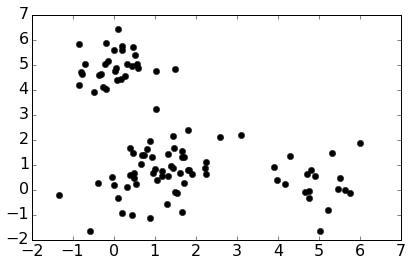

In [15]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [16]:
np.random.seed(4)

# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3

# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


In [17]:

print [k for k,v in results.items()]

['loglik', 'resp', 'covs', 'weights', 'means']


In [18]:
print results['weights']

[0.30071023006098241, 0.17993710074247016, 0.51935266919654743]


###Plot progress of parameters.

In [19]:
import matplotlib.mlab as mlab
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

Iteration 0
Iteration 4
Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


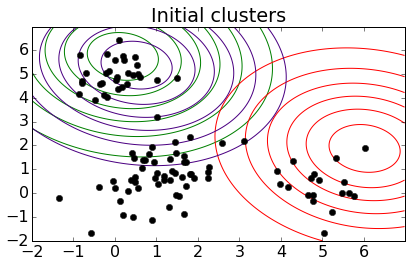

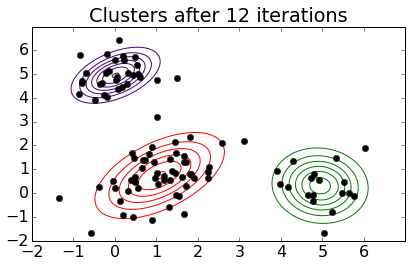

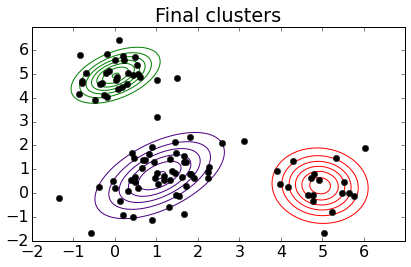

In [20]:
# Parameters after initialization
plot_contours(data, initial_means, initial_covs, 'Initial clusters')

# Parameters after 12 iterations
results = EM(data, init_means, init_covariances, init_weights, maxiter=12) # YOUR CODE HERE
plot_contours(data, results['means'], results['covs'], 'Clusters after 12 iterations')

# Parameters after running EM to convergence
results = EM(data, initial_means, initial_covs, initial_weights)
plot_contours(data, results['means'], results['covs'], 'Final clusters')

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


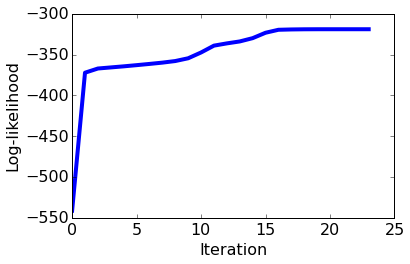

In [21]:
results = EM(data, initial_means, initial_covs, initial_weights)

loglikelihoods = results['loglik']

plt.plot(range(len(loglikelihoods)), loglikelihoods, linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

##Fitting a Gaussian mixture model for image data

In [22]:
import os
from os.path import join
image_list = []
for (dirname, dirs, files) in os.walk('/Users/April/Downloads/images'):
    for filename in files:
        if filename.endswith('.jpg') :
            thefile = os.path.join(dirname,filename)
            image_list.append(thefile)


In [23]:
rgb=[]
for i in image_list:
    img=Image.open(i)
    arr = np.array(img)
    r,g,b = np.mean(arr[:,:,0]/256.0), np.mean(arr[:,:,1]/256.0), np.mean(arr[:,:,2]/256.0)
    rgb.append([r,g,b])

In [24]:
images = pd.DataFrame(rgb, columns = ['r', 'g', 'b'])
images['rgb'] = rgb

In [25]:
images['image'] = image_list

In [26]:
print images.head()

          r         g         b  \
0  0.528536  0.536798  0.546718   
1  0.416127  0.567949  0.760861   
2  0.345726  0.470252  0.647845   
3  0.529008  0.541079  0.543306   
4  0.439874  0.471199  0.498986   

                                                rgb  \
0  [0.528535952127, 0.536798283917, 0.546717975633]   
1  [0.416127340982, 0.567949205534, 0.760861327892]   
2  [0.345726136782, 0.470252451688, 0.647845024355]   
3  [0.529008139329, 0.541078596431, 0.543305763767]   
4   [0.43987363422, 0.471198888966, 0.498986315453]   

                                               image  
0  /Users/April/Downloads/images/cloudy_sky/ANd9G...  
1  /Users/April/Downloads/images/cloudy_sky/ANd9G...  
2  /Users/April/Downloads/images/cloudy_sky/ANd9G...  
3  /Users/April/Downloads/images/cloudy_sky/ANd9G...  
4  /Users/April/Downloads/images/cloudy_sky/ANd9G...  


In [27]:
np.random.seed(1)

# Initalize parameters
init_means = [images['rgb'][x] for x in np.random.choice(len(images), 4, replace=False)]
cov = np.diag([images['r'].var(), images['g'].var(), images['b'].var()])
init_covariances = [cov, cov, cov, cov]
init_weights = [1/4., 1/4., 1/4., 1/4.]

# Convert rgb data to numpy arrays
img_data = [np.array(i) for i in images['rgb']]  

# Run our EM algorithm on the image data using the above initializations. 
# This should converge in about 125 iterations
out = EM(img_data, init_means, init_covariances, init_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 30
Iteration 35
Iteration 40
Iteration 45
Iteration 50
Iteration 55
Iteration 60
Iteration 65
Iteration 70
Iteration 75
Iteration 80
Iteration 84


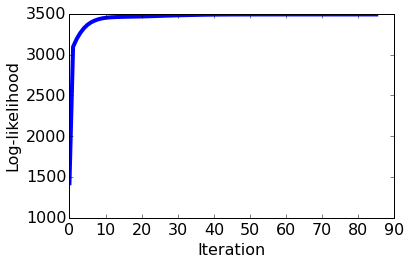

In [28]:
ll = out['loglik']
plt.plot(range(len(ll)),ll,linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

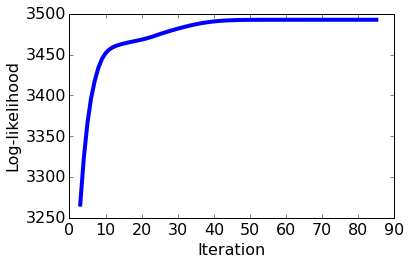

In [29]:
plt.figure()
plt.plot(range(3,len(ll)),ll[3:],linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [30]:
import colorsys
def plot_responsibilities_in_RB(img, resp, title):
    N, K = resp.shape
    
    HSV_tuples = [(x*1.0/K, 0.5, 0.9) for x in range(K)]
    RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
    
    R = img['r']
    B = img['b']
    resp_by_img_int = [[resp[n][k] for k in range(K)] for n in range(N)]
    cols = [tuple(np.dot(resp_by_img_int[n], np.array(RGB_tuples))) for n in range(N)]

    plt.figure()
    for n in range(len(R)):
        plt.plot(R[n], B[n], 'o', c=cols[n])
    plt.title(title)
    plt.xlabel('R value')
    plt.ylabel('B value')
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

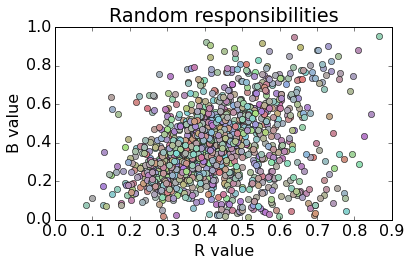

In [31]:
N, K = out['resp'].shape
random_resp = np.random.dirichlet(np.ones(K), N)
plot_responsibilities_in_RB(images, random_resp, 'Random responsibilities')

Iteration 0


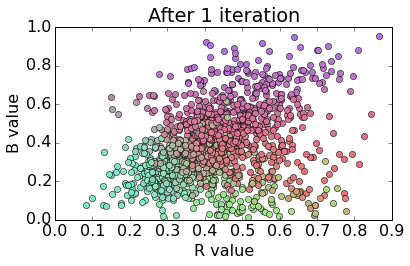

In [32]:
out = EM(img_data, init_means, init_covariances, init_weights, maxiter=1)
plot_responsibilities_in_RB(images, out['resp'], 'After 1 iteration')

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 19


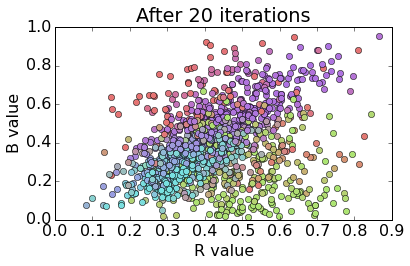

In [33]:
out = EM(img_data, init_means, init_covariances, init_weights, maxiter=20)
plot_responsibilities_in_RB(images, out['resp'], 'After 20 iterations')

##Interpreting each cluster

In [34]:
weights = out['weights']
means = out['means']
covariances = out['covs']
rgb = images['rgb']
N = len(images) # number of images
K = len(means) # number of clusters

assignments = [0]*N
probs = [0]*N

for i in range(N):
    # Compute the score of data point i under each Gaussian component:
    p = np.zeros(K)
    for k in range(K):
        p[k] = weights[k]*multivariate_normal.pdf(rgb[i], mean=means[k], cov=covariances[k])
        
    # Compute assignments of each data point to a given cluster based on the above scores:
    assignments[i] = np.argmax(p)
    
    # For data point i, store the corresponding score under this cluster assignment:
    probs[i] = np.max(p)

assignments = pd.DataFrame({'assignments':assignments, 'probs':probs, 'image': images['image']})

In [35]:
assignments.head()

,assignments,image,probs
0,3,/Users/April/Downloads/images/cloudy_sky/ANd9G...,72.285664
1,0,/Users/April/Downloads/images/cloudy_sky/ANd9G...,1.748629
2,0,/Users/April/Downloads/images/cloudy_sky/ANd9G...,2.431567
3,3,/Users/April/Downloads/images/cloudy_sky/ANd9G...,79.962904
4,3,/Users/April/Downloads/images/cloudy_sky/ANd9G...,100.972515


In [36]:
def get_top_images(assignments, cluster, k=5):
    # YOUR CODE HERE
    images_in_cluster = assignments[assignments['assignments']== cluster]
    top_images = images_in_cluster.sort('probs', ascending = False).head(k)
    return top_images['image']

In [37]:
def display_images(images):
    from IPython.display import Image, display
    
    for image in images:
        display(Image(filename=image))



Component 0


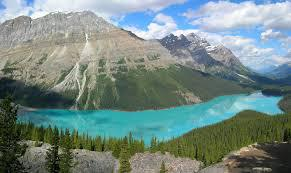

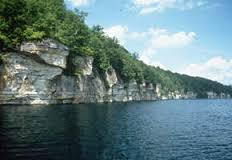

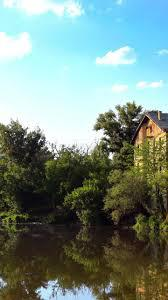

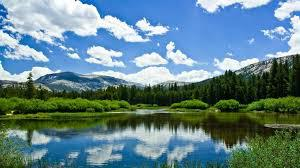

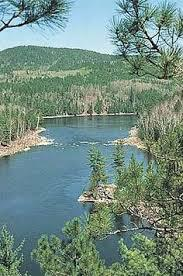



Component 1


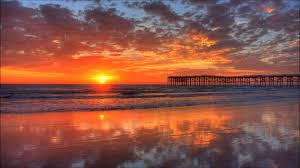

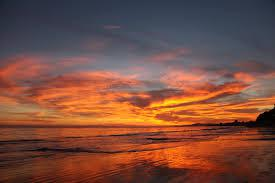

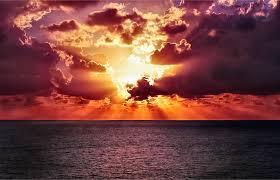

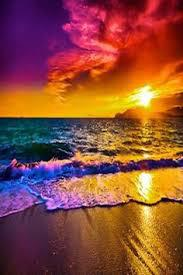

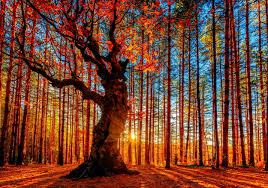



Component 2


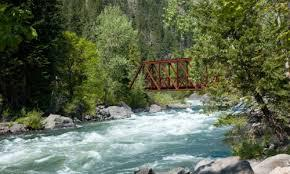

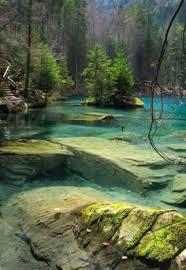

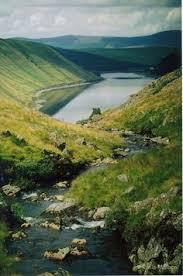

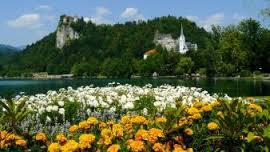

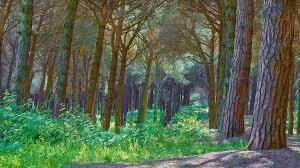



Component 3


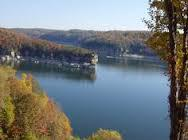

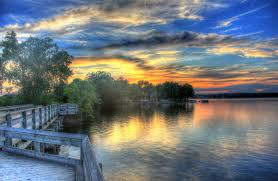

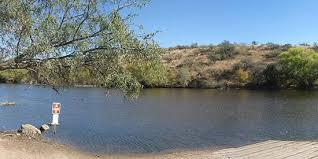

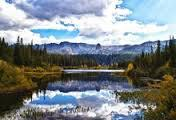

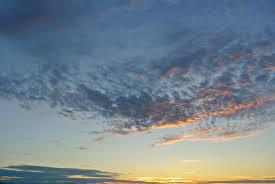

In [38]:
for component_id in range(4):
    print 'Component {0:d}'.format(component_id)
    images = get_top_images(assignments, component_id)
    display_images(images)
    #save_images(images, 'component_{0:d}_%d.jpg'.format(component_id))
    print '\n'

In [39]:
assignments.sort(['assignments', 'probs'], ascending = [True,False]).groupby('assignments').head(5)['image']

646     /Users/April/Downloads/images/rivers/ANd9GcTZ6...
615     /Users/April/Downloads/images/rivers/ANd9GcTqL...
382     /Users/April/Downloads/images/rivers/ANd9GcR3C...
519     /Users/April/Downloads/images/rivers/ANd9GcSn6...
455     /Users/April/Downloads/images/rivers/ANd9GcRup...
738     /Users/April/Downloads/images/sunsets/ANd9GcR3...
902     /Users/April/Downloads/images/sunsets/ANd9GcSr...
994     /Users/April/Downloads/images/sunsets/ANd9GcTw...
871     /Users/April/Downloads/images/sunsets/ANd9GcSd...
1016    /Users/April/Downloads/images/trees_and_forest...
588     /Users/April/Downloads/images/rivers/ANd9GcThH...
408     /Users/April/Downloads/images/rivers/ANd9GcRet...
620     /Users/April/Downloads/images/rivers/ANd9GcTrr...
300     /Users/April/Downloads/images/rivers/ANd9GcQ3w...
1114    /Users/April/Downloads/images/trees_and_forest...
490     /Users/April/Downloads/images/rivers/ANd9GcSD8...
658     /Users/April/Downloads/images/sunsets/ANd9GcQ9...
486     /Users

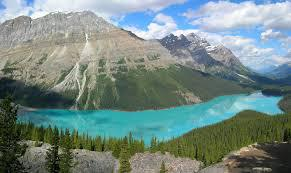

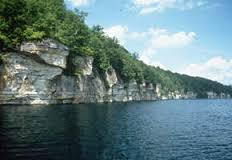

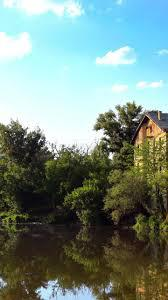

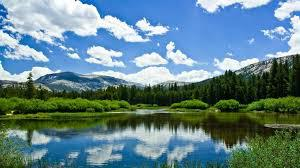

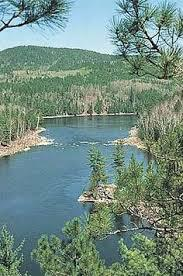

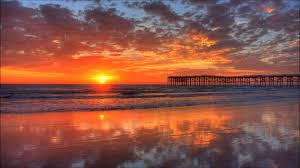

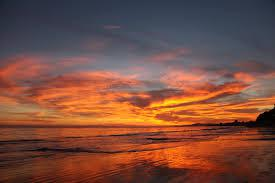

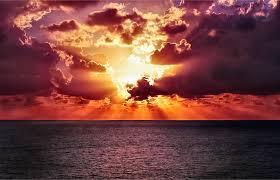

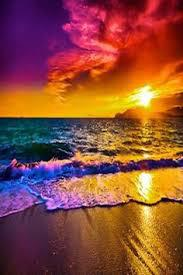

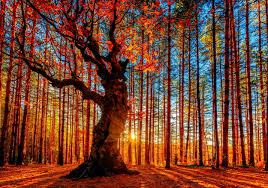

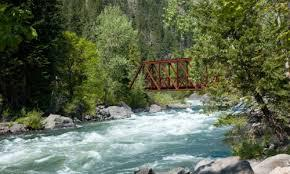

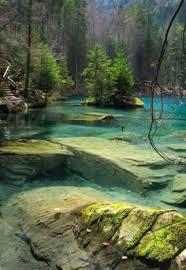

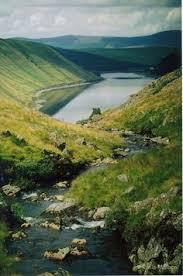

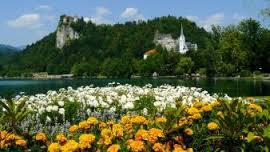

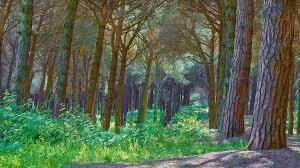

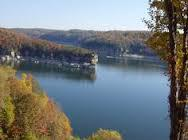

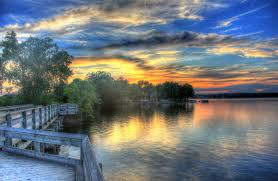

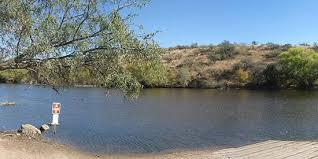

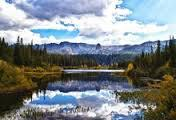

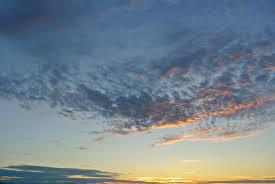

In [40]:
from IPython.display import Image, display

listOfImageNames = [i for i in assignments.sort(['assignments', 'probs'], ascending = [True,False]).groupby('assignments').head(5)['image']]

for imageName in listOfImageNames:
    display(Image(filename=imageName))